In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import pandas as pd
import time
import scipy

#Separate import for numpy and jax.numpy to have major felxibility
import jax.numpy as jnp
import numpy as np
from jax import jit,lax,random
from tensorflow_probability.substrates import numpy as tfp
tfd = tfp.distributions
from tensorflow_probability.substrates import jax as jtfp
jtfd = jtfp.distributions
import jax.scipy as js

np.random.seed(0)

In [48]:
sampled_perturbed = np.load('test4.npy')
#sampled_perturbed=np.genfromtxt('faithful.csv', delimiter=',')
data = sampled_perturbed[0 : 1000]
#DEFINING NUMBER OF CLUSTERS AND DIMENSION OF DATA
k = 10
d = 2
df=7
df_cost=df/(df-2)
#Key to store for random generation
rng_key = random.PRNGKey(0)

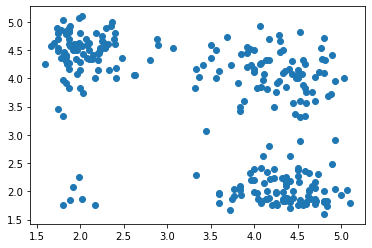

In [49]:
plt.scatter(data[:,0],data[:,1])

In [40]:
from IPython.core.pylabtools import select_figure_formats
@jit
def g(x):
    """
    Function to modulate the Wasserstein Distance
    """
  
    
    f=(5/(1+jnp.exp(-0.6*(x-5))))-0.237

    return f

@jit
def sample_uniq_vals_fullcond_Wasserstein_NW_log(data,cluster_allocs, mus,covs, h,bij,cov_prop_mu,cov_prop_cov,key):
    """
    Perform one step of the Metropolis Hastings to sample a couple (mu,cov) from N*IW*Wasserstein
    """
    
    
    #Starting point of MH
    mu_old = mus[h]
    cov_old = covs[h]
    log_jac_cov_old = abs(bij.forward_log_det_jacobian( bij.inverse(cov_old) ) )
    
    # Sample the proposal using Bijector and compute jacobian term of transformation
    mu, cov, log_jac_cov,key = sample_from_bijector(mu_old, cov_prop_mu, cov_old, cov_prop_cov,bij,key)
    jac_term = log_jac_cov - log_jac_cov_old
    
    # Compute acceptance rate(and return it for tuning)
    beta = compute_beta_NW_log(data,cluster_allocs,mus,covs, h, mu, cov,mu_old, cov_old,jac_term)
    beta = jnp.minimum(0, beta)
    accept_rate = jnp.exp(beta)
    
    key,subk = random.split(key)
    draw = jtfd.Uniform().sample(seed = subk)
    
    # Select the new or old values 
    logic = jnp.log(draw) >= beta
    ret_mu = logic * jnp.array(mu_old) + (1 - logic)*jnp.array(mu)
    ret_cov = logic * jnp.array(cov_old) + (1 - logic)*jnp.array(cov)

    return ret_mu,ret_cov,accept_rate,key
    
    
@jit
def sample_uniq_vals_prior_Wasserstein_NW_log(mus,covs, h,bij,cov_prop_mu,cov_prop_cov,key):
    """
    Perform one step of the Metropolis Hastings to sample a couple (mu,cov) from N*IW*Wasserstein
    """
    
    # Starting point of MH
    mu_old = mus[h]
    cov_old = covs[h]
    log_jac_cov_old = abs(bij.forward_log_det_jacobian( bij.inverse(cov_old) ) )
    
    # Sample the proposal using Bijector and compute jacobian term of transformation
    mu, cov, log_jac_cov,subk1 = sample_from_bijector(mu_old, cov_prop_mu, cov_old, cov_prop_cov,bij,key)
    jac_term = log_jac_cov - log_jac_cov_old
    
    # Compute acceptance rate(and return it for tuning)
    beta = compute_beta_NW_prior_log(mus,covs, h, mu, cov,mu_old, cov_old,jac_term)
    beta = jnp.minimum(0, beta)
    accept_rate = jnp.exp(beta)
    
    key,subk = random.split(key)
    draw = jtfd.Uniform().sample(seed = subk)
    
    # Select the new or old values 
    logic = jnp.log(draw) >= beta
    ret_mu = logic * jnp.array(mu_old) + (1 - logic)*jnp.array(mu)
    ret_cov = logic * jnp.array(cov_old) + (1 - logic)*jnp.array(cov)

    return ret_mu,ret_cov,accept_rate,key
    

@jit
def sample_from_bijector(mu_old, cov_prop_mu, cov_old, cov_prop_cov, bijector,key):
    """
    Sample new mean and covariance matrix through the bijection
    """
    key , subk1 , subk2 = random.split(key,3)

    mix = 0.1
    bimix_gauss = jtfd.MixtureSameFamily(
        
                     mixture_distribution=jtfd.Categorical(probs=[mix, 1-mix]),
                     components_distribution=jtfd.MultivariateNormalDiag(loc=[mu_old,mu_old],scale_diag=[[3,3],[0.1,0.1]])
                   )  

    mu = bimix_gauss.sample(seed = subk1)
    
    chol = jnp.linalg.cholesky(cov_old)
    vec = bijector.inverse(chol)
    vec_sampl = jtfd.MultivariateNormalFullCovariance(vec,cov_prop_cov).sample(seed = subk2)
    cov_sampl = bijector.forward(vec_sampl)
    cov = jnp.matmul(cov_sampl , jnp.transpose(cov_sampl))
    log_jac = abs(bijector.forward_log_det_jacobian(vec_sampl))
    
    return mu,cov,log_jac,key

@jit
def compute_beta_NW_log(data,cluster_allocs,mus,covs, h, mu, cov,mu_old, cov_old,jac_term):
    """
    Compute Metropolis Hastings term, knowing the proposal is symmetric
    The target is the Normal Inverse Wishart with parameters mu_n, lam_n, phi_n, nu_n
    """
    nan_vec = jnp.repeat(jnp.array([jnp.nan]),len(cluster_allocs))
    
    mu_0 = jnp.zeros(2)
    cov_0 = jnp.eye(2)
    nu_0 = 5
    phi_0 = jnp.eye(2)*(nu_0-3)
    
    # NW distribution terms
    num_0 = evaluate_NW_log(mu, cov, mu_0, cov_0, phi_0, nu_0)
    den_0 = evaluate_NW_log(mu_old, cov_old , mu_0, cov_0, phi_0, nu_0)
    
    # Data distribution terms
    
    eval_vec=evaluate_student_T(data,mu,cov,df)
    eval_vec_old=evaluate_student_T(data,mu_old,cov_old,df)
    
    num_1 = jnp.nansum( jnp.where(cluster_allocs == h,eval_vec,nan_vec))
    den_1 = jnp.nansum( jnp.where(cluster_allocs == h,eval_vec_old,nan_vec))


    
     # Wasserstein Distance terms
    wass_arr = jnp.array([jnp.log(compute_Wasserstein(mu , cov , mus[j] , covs[j])) - jnp.log(compute_Wasserstein(mu_old , cov_old , mus[j], covs[j])) for j in range(k)])
    cond_arr = jnp.arange(k)
    nan_arr = jnp.repeat(jnp.nan,k)
    sum_ = jnp.nansum(jnp.where(cond_arr != h,wass_arr,nan_arr))

    return num_0 + num_1  - den_0 - den_1 + sum_ + jac_term

@jit
def compute_beta_NW_prior_log(mus,covs, h, mu, cov,mu_old, cov_old,jac_term):
    """
    Compute Metropolis Hastings term, knowing the proposal is symmetric
    The target is the Normal Inverse Wishart with parameters mu_n, lam_n, phi_n, nu_s the Normal Inverse Wishart with parameters mu_n, lam_n, phi_n, nus the Normal Inverse Wishart with parameters mu_n, lam_n, phi_n, nu_s the Normal Inverse Wishart with parameters mu_n, lam_n, phi_n, nu_"s the Normal Inverse Wishart with parameters mu_n, lam_n, phi_n, nu_s the Normal Inverse Wishart with parameters mu_n, lam_n, phi_n, nus the Normal Inverse Wishart with parameters mu_n, lam_n, phi_n, nu_s the Normal Inverse Wishart with parameters mu_n, lam_n, phi_n, nu_"n
    """
    
    mu_0 = jnp.zeros(2)
    cov_0 = jnp.eye(2)
    nu_0 = 5
    phi_0 = jnp.eye(2)*(nu_0-3)
    
    # NW distribution terms
    num = evaluate_NW_log(mu, cov, mu_0, cov_0, phi_0, nu_0)
    den = evaluate_NW_log(mu_old, cov_old , mu_0, cov_0, phi_0, nu_0)
    
    # Wasserstein Distance terms
    wass_arr = jnp.array([jnp.log(compute_Wasserstein(mu , cov , mus[j] , covs[j])) - jnp.log(compute_Wasserstein(mu_old , cov_old , mus[j], covs[j])) for j in range(k)])
    cond_arr = jnp.arange(k)
    nan_arr = jnp.repeat(jnp.nan,k)
    sum_ = jnp.nansum(jnp.where(cond_arr != h,wass_arr,nan_arr))
    
    return num  - den + sum_ + jac_term
  
@jit
def evaluate_NW_log(x_mu, x_cov, mu_n, cov_n, phi_n, nu_n):
    """
    Evaluate the likelihood: L[ (x_mu, x_cov) | ( mu_n, cov_n, phi_n, nu_n ) ]
    L = Normal x Inverse Wishart
    """
    W = jnp.linalg.inv(phi_n)
    chol = jnp.linalg.cholesky(W) 
    inv_cov = jnp.linalg.inv(x_cov)

    f1 = jtfd.WishartTriL(df=nu_n.astype(float), scale_tril=chol).log_prob(inv_cov)
    f2 = jtfd.MultivariateNormalFullCovariance(mu_n, cov_n).log_prob(x_mu)
    
    return f1 + f2

@jit
def compute_Wasserstein(mu_1, cov_1, mu_2, cov_2):
    """
    Wasserstein distance for the Student-t Case, already taking consideration of g() to bound Wasserstein term
    """
    norm = jnp.linalg.norm(mu_1 - mu_2, ord = 2)
    
    #Compute square root of cov_2
    s = jnp.sqrt(jnp.linalg.det(cov_2))
    t = jnp.sqrt(jnp.trace(cov_2) + 2*s)
    sqrt_C2 = 1/t * (cov_2 + s*jnp.eye(2))
    
    C1_sqrt_C2 = jnp.matmul(cov_1,sqrt_C2)
    sqrt_C2_C1_sqrt_C2 = jnp.matmul(sqrt_C2,C1_sqrt_C2)
    
    #Compute square root of sqrt_C2_C1_sqrt_C2
    s = jnp.sqrt(jnp.linalg.det(sqrt_C2_C1_sqrt_C2))
    t = jnp.sqrt(jnp.trace(sqrt_C2_C1_sqrt_C2) + 2*s)
    mat_sqrt = 1/t * (sqrt_C2_C1_sqrt_C2 + s*jnp.eye(2))
    
    trace = jnp.trace(cov_1 + cov_2 - 2 * mat_sqrt)

    # Function g
    return g(norm+trace)

@jit
def update_weights(cluster_allocs, weights, k, alpha,key):

    key, subk = random.split(key)
    n_clus = len(weights)
    n_by_clus = jnp.array([jnp.sum(cluster_allocs == h) for h in range(n_clus)])
    post_params = jnp.ones(n_clus) * alpha + n_by_clus
    return jtfd.Dirichlet(post_params.astype(float)).sample(seed = subk),key











In [41]:
@jit
def evaluate_student_T(data,mu,cov,df):
  
  scale=cov*(df-2)/df
  inv_scale=jnp.linalg.inv(scale)
  det_scale=jnp.linalg.det(scale)
  p=2
  
  def inner_f (x):
    eval_vec=js.special.gammaln((df+p)/2)-js.special.gammaln(df/2)-0.5*jnp.log(jnp.power(df,p)*jnp.power(jnp.pi,p)*det_scale)-((df+p)/2)*jnp.log(1+(1/df)*(jnp.dot((x-mu).T ,jnp.dot(inv_scale, x-mu))))
    return eval_vec
  ris=jnp.apply_along_axis(inner_f,1,data)
  
  return ris
 
def update_cluster_allocs(data, weights, mus, covs,key):
    key, subk = random.split(key)
    logprobs=[]
    for h in range(k):
      v=evaluate_student_T(data,mus[h],covs[h],df)
      v=np.expand_dims(v,axis=1)
      if (h==0):
        logprobs=v
      else:
        logprobs=np.concatenate((logprobs,v),axis=1)
    logprobs += jnp.log(weights)
    probs =  jnp.exp(logprobs)/(jnp.sum(jnp.exp(logprobs), axis=1))[:,None]
    return jtfd.Categorical(probs=probs, validate_args=True).sample(seed = subk),key

In [42]:
def run_one_gibbs(data, cluster_allocs, mus,covs, weights, alpha,bij,cov_prop_mu,cov_prop_cov,key):
    """
    Run one gibbs sampler iteration
    Takes in input values of the previous iteration and sample the new values from sample_uniq_vals_fullcond, update_weights and update_cluster_allocs
    Returns:   
    
    -cluster_allocs: for every data point, the cluster assigned
    -uniq_vals: array of parameters of the distributions. Matrix has d rows of the type:[mu[0], var[0,0], var[0,1]]
    -weights: array with the weights of the clusters 
     """
    key, subk = random.split(key)
    n_clus = len(weights)
    for h in range(n_clus):
        
        #Extract data assigned to cluster h and sample 
        clusdata = data[cluster_allocs == h]
        if(len(clusdata) != 0):
            mus[h],covs[h], acc_rate,key = sample_uniq_vals_fullcond_Wasserstein_NW_log(data,cluster_allocs, mus,covs, h,bij,cov_prop_mu,cov_prop_cov,key)
        else:
            mus[h],covs[h], acc_rate,key = sample_uniq_vals_prior_Wasserstein_NW_log(mus,covs, h,bij,cov_prop_mu,cov_prop_cov,key)


    weights,key = update_weights(cluster_allocs ,weights, k, alpha,key)

    cluster_allocs,key = update_cluster_allocs(data, weights, mus,covs,key)

    return cluster_allocs, mus,covs, weights, acc_rate,key

def run_mcmc(data, k, key , niter=1000, nburn=300, thin=5 ): 
    """
    Runs entire MCMC
    Takes in input data, number of clusters, number of iterations, burn-in and thin
    Returns the parameters recorded after burn-in phase
    """

    b = time.time() # only to measure time
    
    #Bijector setup
    jtfb = jtfp.bijectors
    bij = jtfb.Chain([
            jtfb.TransformDiagonal(jtfb.Softplus()),
            jtfb.FillTriangular()])

    #Starting Values
    cluster_allocs = tfd.Categorical(probs=np.ones(k) / k).sample(len(data))
    weights = jnp.ones(k)/k
    alpha = 0.1
    lam = 0.1
    mus = np.array(jtfd.MultivariateNormalFullCovariance(np.mean(np.array(data), axis=0), np.linalg.inv(np.diag(np.ones(d))/lam) ).sample(k,seed = key))
    covs = np.array(jtfd.WishartTriL(df=d, scale_tril=tf.linalg.cholesky(np.eye(2)) ).sample(k,seed = key))
    
    #Proposal Covariances
    cov_prop_cov = 0.02 * jnp.eye(3) #covariance matrix for the covariance sampling
    cov_prop_mu = jnp.eye(2)   #covariance matrix for the mean sampling
    
    #Output values
    allocs_out = []
    mus_out = []
    covs_out = []
    weights_out = []
    acc_rates = []
    
    #Useful value
    data_mean = np.mean(data, axis = 0)
    
    #Iterations
    for i in range(niter):
        cluster_allocs, mus,covs, weights, acc_rate,key = run_one_gibbs(
            data, cluster_allocs, mus,covs, weights, alpha,bij,cov_prop_mu,cov_prop_cov,key)
        acc_rates.append(acc_rate)
        
        if i > nburn and i % thin == 0:
            allocs_out.append(cluster_allocs)
            mus_out.append(mus.copy())
            covs_out.append(covs.copy())
            weights_out.append(weights)
            
        if i % 10 == 0 and i > 11:
            a = time.time()
            print("\rIter {0} / {1}".format(i+1, niter) + " Remaining minutes: " + str(round((a-b)*(niter-i)/(60*10) ,1)) , flush=False, end=" ")
            b = time.time()
            print("Acceptance rate: " + str(np.mean(acc_rates[-10:])))
            
    return allocs_out, mus_out,covs_out, weights_out,acc_rates

In [50]:
#RUNNING THE MCMC
start = time.time()
allocs_out, mus_out,covs_out, weights_out,accept_rate_out = run_mcmc(data, k,rng_key , niter = 3000,nburn = 1000,thin = 5)
end = time.time()
print("Total time: " + str(end-start))

/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:6493: UserWarning: Explicitly requested dtype <class 'numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")
/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:6493: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")
/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:3552: UserWarning: Explicitly requested dtype <class 'numpy.flo

Iter 21 / 3000 Remaining minutes: 7.3 Acceptance rate: 0.24179044
Iter 31 / 3000 Remaining minutes: 2.3 Acceptance rate: 0.17781088
Iter 41 / 3000 Remaining minutes: 2.3 Acceptance rate: 0.25150865
Iter 51 / 3000 Remaining minutes: 2.4 Acceptance rate: 0.121878624
Iter 61 / 3000 Remaining minutes: 2.4 Acceptance rate: 0.035077162
Iter 71 / 3000 Remaining minutes: 2.4 Acceptance rate: 0.11665992
Iter 81 / 3000 Remaining minutes: 2.5 Acceptance rate: 0.11997805
Iter 91 / 3000 Remaining minutes: 2.3 Acceptance rate: 0.11021043
Iter 101 / 3000 Remaining minutes: 2.4 Acceptance rate: 0.06322923
Iter 111 / 3000 Remaining minutes: 2.3 Acceptance rate: 0.11386987
Iter 121 / 3000 Remaining minutes: 2.3 Acceptance rate: 0.14974183
Iter 131 / 3000 Remaining minutes: 2.3 Acceptance rate: 0.030667027
Iter 141 / 3000 Remaining minutes: 2.3 Acceptance rate: 0.25880468
Iter 151 / 3000 Remaining minutes: 2.3 Acceptance rate: 0.19896606
Iter 161 / 3000 Remaining minutes: 2.3 Acceptance rate: 0.17457448


In [51]:
def get_psm(clus_alloc_chain):
    """
    Returns the posterior similarity matrix, i.e.
        out[i, j] = P(c_i == c_j | all the rest)
    for each pair of observations
    """
    #Fare confronto tra colonna i e j della matrice e poi calcolare da li
    c_chain = np.vstack(clus_alloc_chain)
    out = np.zeros((c_chain.shape[1], c_chain.shape[1]))
    for i in range(c_chain.shape[1]):
        for j in range(c_chain.shape[1]):
            out[i,j] = np.sum(c_chain[:,i] == c_chain[:,j]) / c_chain.shape[0]
            
    return out


def minbinder_sample(clus_alloc_chain, psm):
    """
    Finds the iteration for which the Binder loss is minimized
    and returns the associated clustering
    """
    losses = np.zeros(len(clus_alloc_chain))
    c_chain = np.vstack(clus_alloc_chain)
    
    # You can either cycle through the iterations, or 
    # cycle through the entries in the PSM [i, j]
    # and vectorize the same operation for each iteration!
    
    mat = np.zeros( ( c_chain.shape[0], c_chain.shape[1]**2 ) )
    k = 0
    for i in range(c_chain.shape[1]):
        for j in range(c_chain.shape[1]):
            mat[:,k] = ( (c_chain[:,i] == c_chain[:,j]).astype(int) - psm[i,j] * np.ones(c_chain.shape[0]) ) **2
            k = k+1
    
    losses = np.sum(mat, axis = 1)
    
    best_iter = np.argmin(losses)
    return clus_alloc_chain[best_iter]



def unique_vals_given_clus(unique_vals_chain, clus_alloc_chain, best_clus,n_clus):
    #Finds the unique values associated to the best clusters obtained during MCMC
    
    c_allocs = np.stack(clus_alloc_chain)
    uniq_vals = np.stack(unique_vals_chain)
    means = uniq_vals[:, :, : , 0]
    variances = uniq_vals[:, :, : , 1:3]
    out1 = []
    out2 = []
    for h in range(n_clus):
        data_idx = np.where(best_clus == h)[0]
        uniq_vals_idx = c_allocs[:, data_idx] # -> Matrix [n_iter x n_data_in_clus]
        means_by_iter = np.empty((c_allocs.shape[0], len(data_idx),2))
        vars_by_iter = np.empty((c_allocs.shape[0], len(data_idx),2,2))
        for i in range(c_allocs.shape[0]):
            means_by_iter[i, :] = means[i,uniq_vals_idx[i,:],:]
            vars_by_iter[i, :] = variances[i,uniq_vals_idx[i,:]]

        avg_mean_by_iter = np.mean(means_by_iter , axis = 1)
        avg_var_by_iter = np.mean(vars_by_iter , axis = 1)
        
        muhat = np.mean(avg_mean_by_iter,axis=0)
        sigsqhat = np.mean(avg_var_by_iter,axis=0)
        out1.append(np.array(muhat))
        out2.append(np.array(sigsqhat))
    
    #If there are no points in certain clusters, the output would be full of NANs for the cluster. This gives problems
    #I replace the NANs with some 0
    for i in range(len(out1)):
        if(np.any(np.isnan(out1[i]))):
            out1[i] = np.zeros(shape = out1[i].shape)
        if(np.any(np.isnan(out2[i]))):
            out2[i] = np.eye(N = out2[i].shape[0])
    
        
    return out1,out2


psm = get_psm(allocs_out)
best_clus = minbinder_sample(allocs_out,psm)

uniq_vals_out = []
for n in range(len(mus_out)):
    mus = mus_out[n]
    covs = covs_out[n]
    arr = np.zeros(shape=(k,2,3))
    for i in range(k):
        mu = mus[i]
        cov = covs[i]
        arr[i,:,:] = np.array( [ [mu[0],cov[0,0],cov[0,1]] , [mu[1],cov[1,0],cov[1,1]] ])
    uniq_vals_out.append(arr)
    
mu_lis,var_lis = unique_vals_given_clus(uniq_vals_out, allocs_out, best_clus,k)
weights = np.sum(best_clus == np.arange(k)[:, np.newaxis], axis=1) / len(data)



/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


9    91
3    91
4    83
2     6
dtype: int64


<BarContainer object of 4 artists>

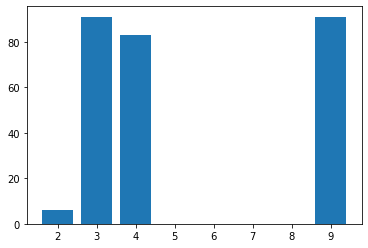

In [52]:
#View the number of points inside each cluster at the best iteration
print(pd.Series(best_clus).value_counts())
x, y = np.unique(best_clus, return_counts=True)
plt.bar(x, y)

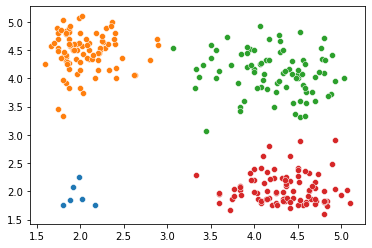

In [53]:
for h in range(k):
    currd = data[best_clus == h]
    sns.scatterplot(x=[elem[0] for elem in currd], y=[elem[1] for elem in currd])

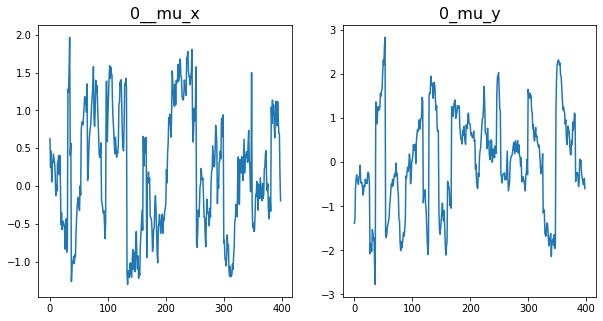

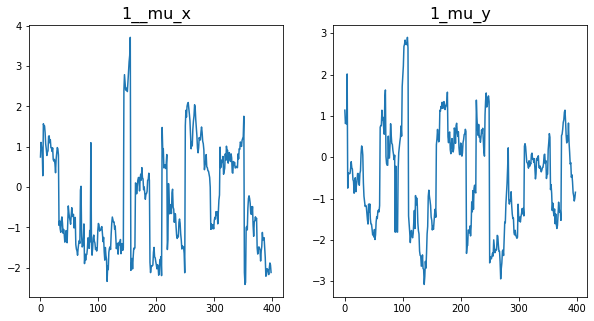

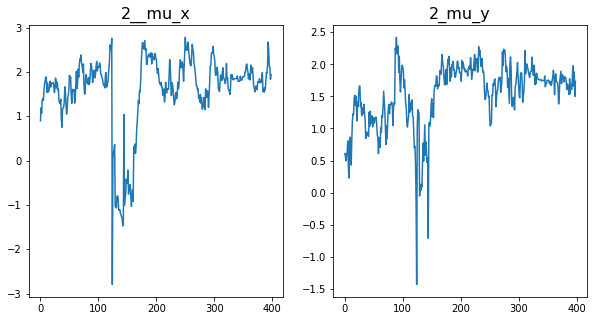

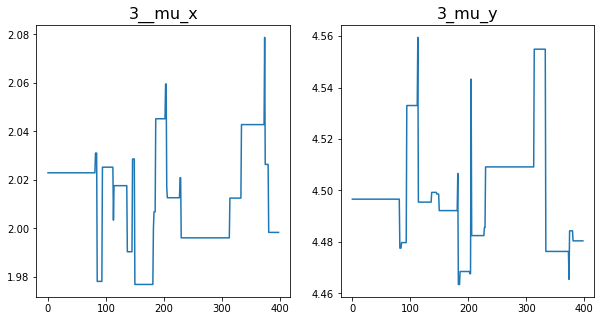

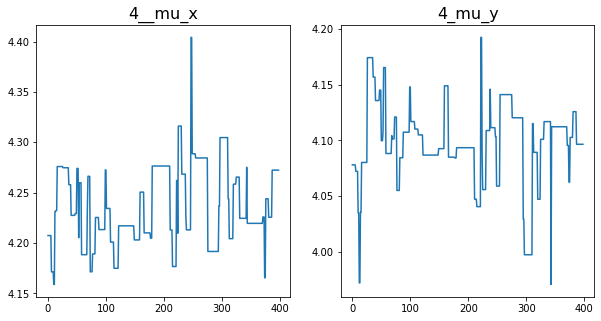

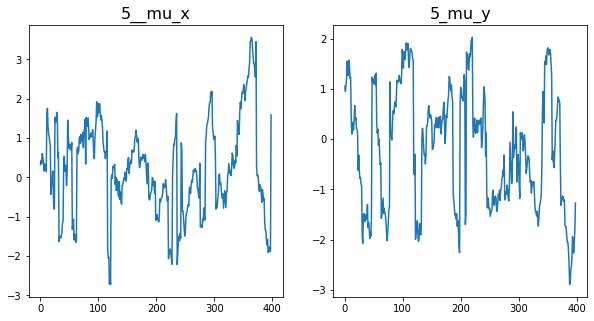

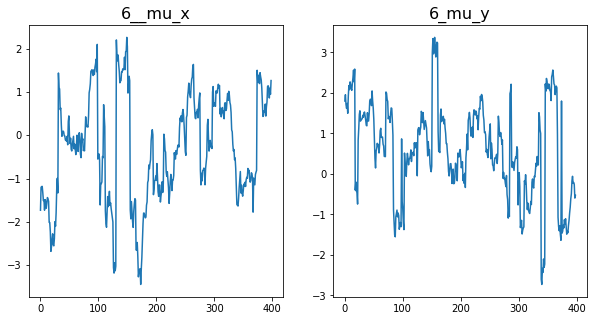

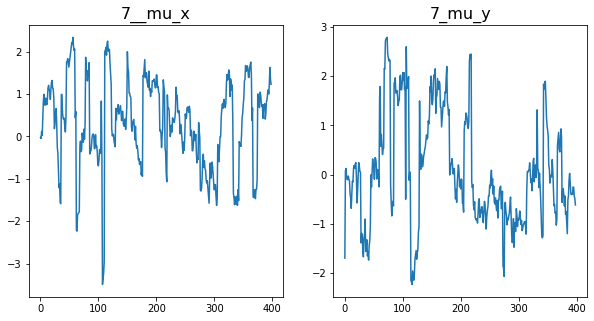

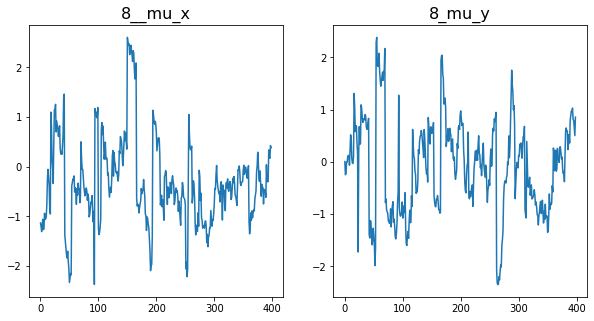

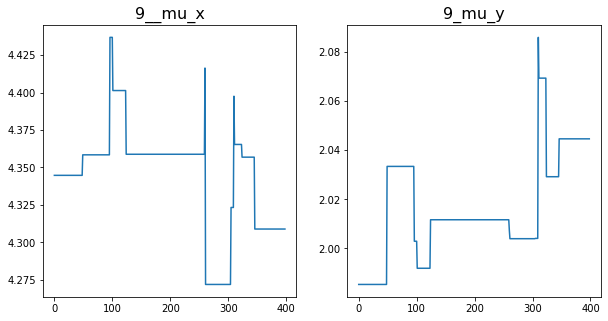

In [54]:
for i in range(k):
    
    #Get mean of the first gaussian component
    first_comp = [mu[i][0] for mu in mus_out]
    second_comp = [mu[i][1] for mu in mus_out]

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

    axes[0].plot(np.arange(len(first_comp)), first_comp)
    axes[0].set_title(str(i) + "__mu_x", fontsize=16)

    axes[1].plot(np.arange(len(second_comp)), second_comp,)
    axes[1].set_title(str(i) + "_mu_y", fontsize=16)

    plt.show()

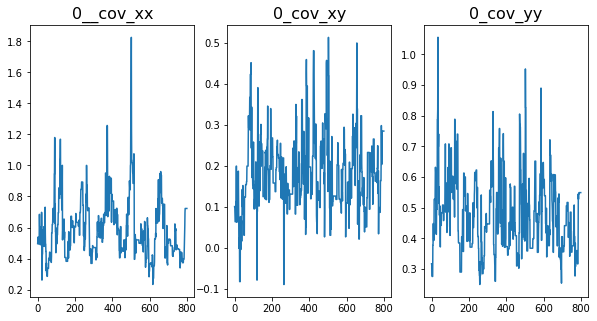

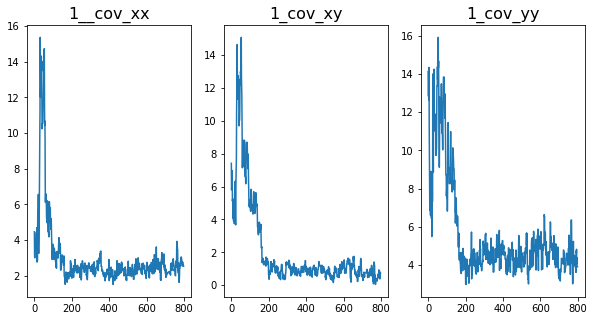

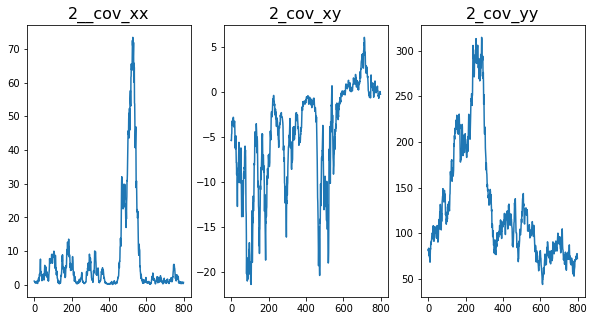

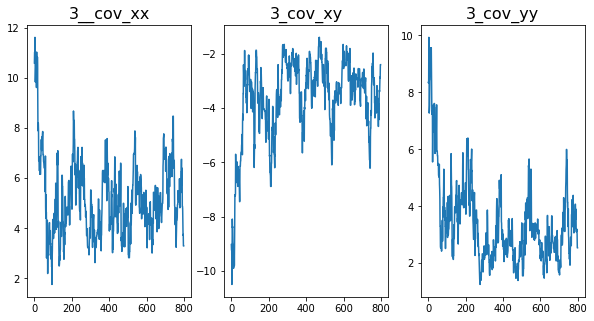

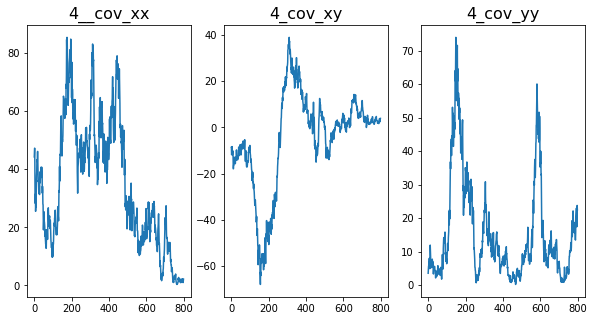

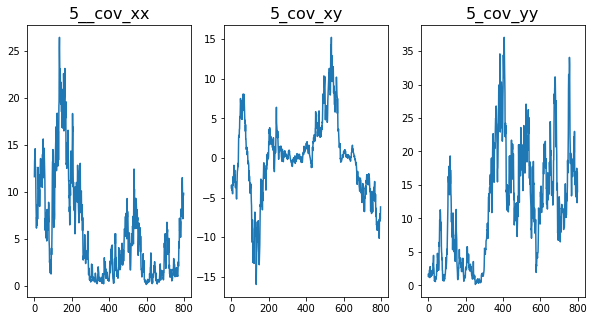

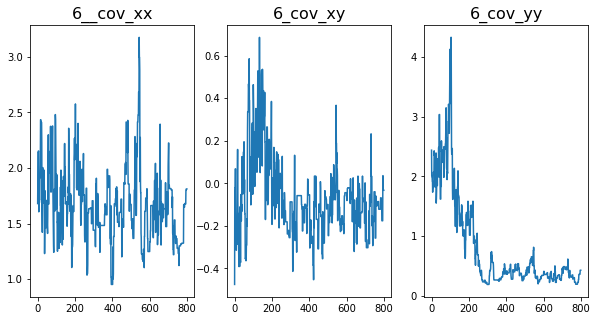

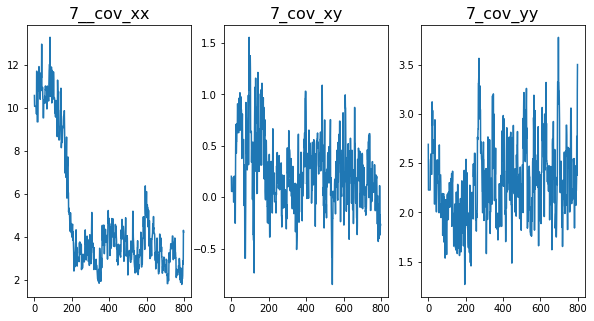

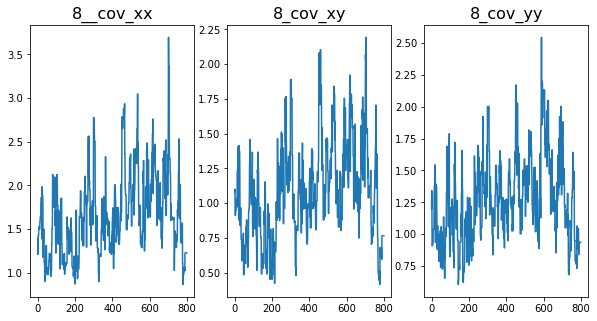

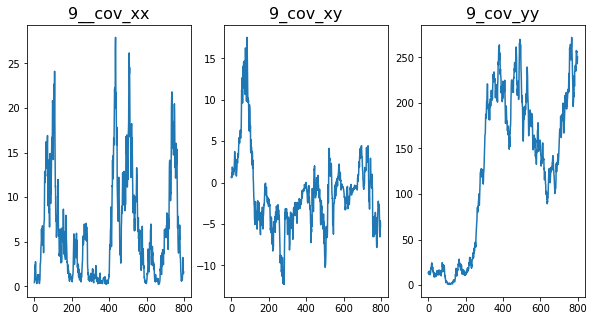

In [13]:
for i in range(k):
    
    #Get mean of the first gaussian component
    first_comp = [covs[i][0,0] for covs in covs_out]
    second_comp = [covs[i][0,1] for covs in covs_out]
    third_comp = [covs[i][1,1] for covs in covs_out]

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))

    axes[0].plot(np.arange(len(first_comp)), first_comp)
    axes[0].set_title(str(i) + "__cov_xx", fontsize=16)

    axes[1].plot(np.arange(len(second_comp)), second_comp,)
    axes[1].set_title(str(i) + "_cov_xy", fontsize=16)
    
    axes[2].plot(np.arange(len(third_comp)), third_comp,)
    axes[2].set_title(str(i) + "_cov_yy", fontsize=16)

    plt.show()

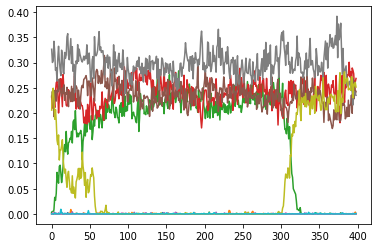

In [26]:
for i in range(k):
    weights = [w[i] for w in weights_out]
    plt.plot(np.arange(len(weights)) , weights)
    